In [ ]:
import importlib
from SOAEpeaks import load_df
import phaseco as pc
from phaseco import *
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import scipy as sp
from scipy.signal.windows import gaussian
from scipy.optimize import curve_fit
import os

# FUNCTIONS

def get_is_signal(coherences, f, xis, f_target_idx, f_noise=12000, sample_hw=5, z_alpha=0.05, crop=False):
    f_noise_idx = (np.abs(f - f_noise)).argmin()  # find frequency bin index closest to our 12kHz cutoff
    # Get mean and std dev of coherence (over frequency axis, axis=0) for each xi value (using only "noise" frequencies above our cutoff)
    noise_means = np.mean(coherences[f_noise_idx:, :], axis=0) 
    noise_stds = np.std(coherences[f_noise_idx:, :], axis=0, ddof=1) # ddof=1 since we're using sample mean (not true mean) in sample std estimate
    # Now for each xi value, run a z-test to see if it's noise or not
    is_signal = np.full(len(xis), True, dtype=bool)
    for xi_idx in range(len(xis)):
        # Skip xi values that are too close to the edges to get a full sample
        if xi_idx < sample_hw:
            is_signal[xi_idx] = True
            continue
        elif xi_idx >= len(xis) - sample_hw:
            is_signal[xi_idx] = False
        coherence_sample = coherences[f_target_idx, xi_idx - sample_hw: xi_idx + sample_hw]
        # Calculate z test statistic
        sample_mean = np.mean(coherence_sample)
        z = (sample_mean - noise_means[xi_idx]) / (noise_stds[xi_idx]/np.sqrt(len(coherence_sample)))
        # Calculate p-value for a one-tailed test (sf = survival function = 1 - cdf)
        p = sp.stats.norm.sf(z)
        is_signal[xi_idx] = p < z_alpha
    target_coherences=coherences[f_target_idx, :]
    if crop:
        is_signal = is_signal[sample_hw:-sample_hw]
        xis = xis[sample_hw:-sample_hw]
        target_coherences = target_coherences[f_target_idx, sample_hw:-sample_hw]
    
    decayed_idx = -1
    # Find decayed point
    for i in range(len(is_signal)):
        if not crop and i < sample_hw: # These are automatically set to signal anyway but what the heck
            continue
        if not is_signal[i]:
            decayed_idx = i
            break
    if decayed_idx == -1:
        print(f"Signal at {f[f_target_idx]:.0f}Hz never decays!")
    xi_decayed = xis[decayed_idx]
    
    return is_signal, xis, target_coherences, xi_decayed, decayed_idx

def exp_decay(x, tc, amp):
    return amp * np.exp(-x/tc)

def gauss_decay(x, tc, amp):
    return amp * np.exp(-x**2/tc)

def sigmoid_amp(x, tc, amp):
    return amp / (1 + np.exp((x)/tc))

def sigmoid_loc(x, tc, loc):
    return 1 / (1 + np.exp((x-loc)/tc))

def sigmoid_amp_loc(x, tc, amp, loc):
    return amp / (1 + np.exp((x-loc)/tc))

# Get different species
df = load_df(laptop=True, dfs_to_load=["Curated Data"])
wf_list = []
for species in ['Anolis', 'Owl', 'Human']:
    df_species = df[df['species'] == species]
    for i in range (3):
        row = df_species.iloc[i]
        wf_fn = row['filepath'].split('\\')[-1]
        wf_list.append((row['wf'], row['sr'], wf_fn, species))
del df



Fitting gauss to 1225Hz Peak with A in [0, 1] on anole_AC6rearSOAEwfB1.mat with rho=0.7
Fitting successful!
0.0012063149968147503
0.5605555988936664
Fitting exp to 1225Hz Peak with A in [0, 1] on anole_AC6rearSOAEwfB1.mat with rho=0.7
Fitting successful!
0.023516171007751774
0.8562219909691235


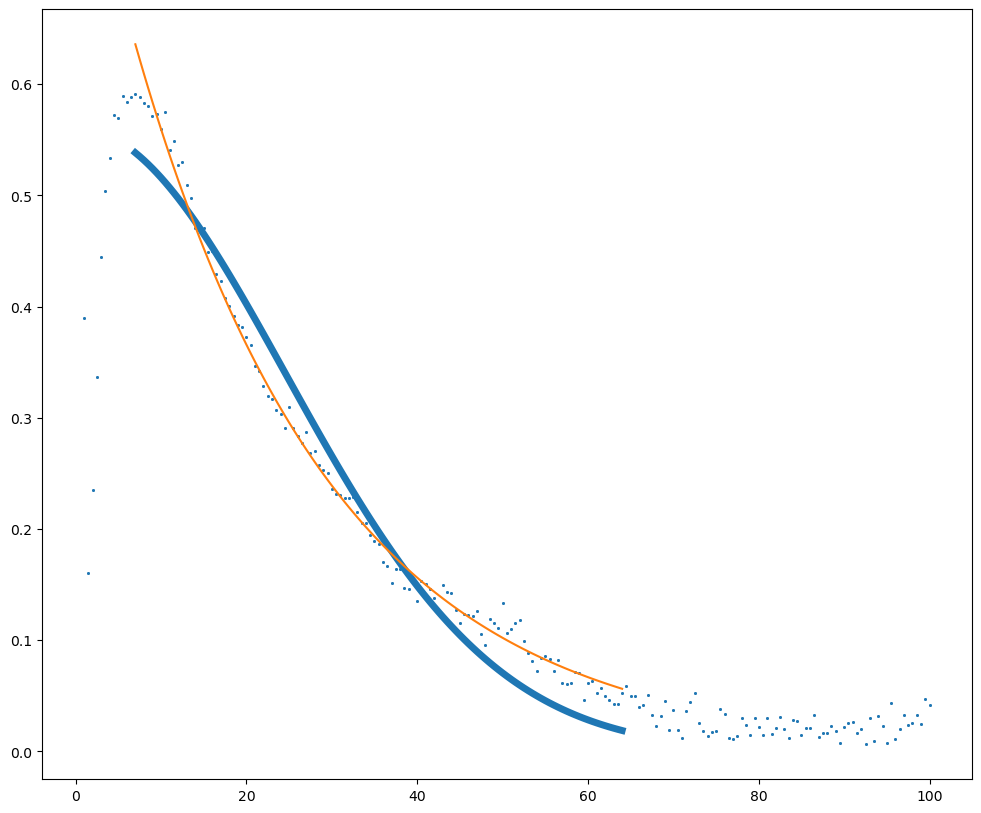

In [23]:


# Run various loops 
for rho in [0.7]:
    # for A_max in [1, np.inf]:
    for A_max in [1]:
        plt.close('all')
        plt.figure(figsize=(12, 10))
        for fit_func_type in ['gauss', 'exp']:
        # for fit_func_type in ['exp', 'gauss', 'sigmoid_amp', 'sigmoid_loc', 'sigmoid_amp_loc']:
            # Skip some of the combos
            if (fit_func_type == 'sigmoid_amp') and (A_max == 1): # This kills all ability to fit
                continue
            if (fit_func_type == 'sigmoid_loc') and (A_max == 1): # A isn't even a parameter so just do one
                continue
            
            for wf_idx in [0]:
            # for wf_idx in [0, 2, 4, 5, 6, 7]: # Started with 0, 2 (Lizard) - 4, 5 (Owl) - 6, 7 (Human)
                wf, fs, wf_fn, species = wf_list[wf_idx]

                # Set parameters (same for human and lizard)
                # rho = 0.7
                tau = 2**12 / 44100 # Everyone uses the same tau
                tauS = int(tau*fs)
                # Raise warning if tauS is not a power of two AND the samplerate is indeed 44100
                if np.log2(tauS) != int(np.log2(tauS)):
                    if fs == 44100:
                        raise ValueError("tauS is not a power of 2, but the samplerate is 44100!")
                    # else:
                    #     print(f"WARNING: tauS is not a power of 2, but the samplerate is {fs} (not 44100), so we'll assume you're just ensuring tau aligns with other waveforms!")

                

                if species == 'Human':
                    # Human parameters
                    min_xi = 0.001
                    max_xi = 1
                    delta_xi = 0.001
                    if wf_fn == 'human_TH14RearwaveformSOAE.mat':
                        max_xi = 2.5
                    max_khz = 6
                elif species in ['Lizard', 'Anolis']:
                    # Lizard parameters
                    min_xi = 0.001
                    max_xi = 0.1
                    delta_xi = 0.0005
                    max_khz = 6
                elif species == 'Owl':
                    # Owl parameters
                    min_xi = 0.001
                    max_xi = 0.1
                    delta_xi = 0.0005
                    max_khz = 12


                    
                    
                # Open coherences, or calculate if needed
                suptitle=rf"[{wf_fn}]   [$\rho$={rho}]   [$\tau$={tau*1000:.2f}ms]"
                fn_id = rf"tau={tau*1000:.0f}, rho={rho}, {species}, {wf_fn.split('.')[0]}"
                pkl_fn = f'C_xi Decay Coherences - {fn_id}'
                pkl_folder = r'Pickles/'
                fig_folder = r'Colossogram Figures/C_xi Decay Figures/'
                
                
                if os.path.exists(pkl_folder + pkl_fn + '.pkl'):
                    with open(pkl_folder + pkl_fn + '.pkl', 'rb') as file:
                        coherences, f, xis, tau, rho, wf_fn, species = pickle.load(file)
                else:
                    print(f"Calculating coherences for {wf_fn} with rho={rho}")
                    num_xis = int((max_xi - min_xi) / delta_xi) + 1
                    xis = np.linspace(min_xi, max_xi, num_xis)

                    max_xiS = max(xis) * fs
                    f = rfftfreq(tauS, 1/fs)
                    # Make sure we have a consistent number of segments to take vector strength over since this will change with xi
                    N_segs = int((len(wf) - tauS) / max_xiS)    

                    coherences = np.zeros((len(f), len(xis)))
                    for i, xi in enumerate(xis):
                        coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]
                    
                    with open(pkl_folder + pkl_fn + '.pkl', 'wb') as file:
                        pickle.dump((coherences, f, xis, tau, rho, wf_fn, species), file)
                    
                
                # Peak pick the target bins
                if wf_fn == 'anole_AC6rearSOAEwfB1.mat': # 0
                    peak_freqs = [1225, 2150, 4300]
                    noise_freqs = [400, 12000]
                elif wf_fn == 'anole_ACsb18learSOAEwfG4.mat': # 2
                    peak_freqs = [990, 2000, 3670]
                    noise_freqs = [400, 12000]
                elif wf_fn == 'owl_Owl6L1.mat': # 4
                    peak_freqs = [4867, 6384, 7235]
                    noise_freqs = [400, 12000]
                elif wf_fn == 'owl_TAG4learSOAEwf1.mat': # 5
                    peak_freqs = [6280, 7820, 10487]
                    noise_freqs = [400, 12000]
                elif wf_fn == 'human_TH14RearwaveformSOAE.mat': # 6
                    peak_freqs = [603, 2250, 4370]
                    noise_freqs = [400, 12000]
                elif wf_fn == 'human_TH21RearwaveformSOAE.mat': # 7
                    peak_freqs = [2000, 2605, 4135]
                    noise_freqs = [400, 12000]
                else:
                    raise(Exception("Haven't peak picked this waveform yet!"))
                    

                bin_idxs = []
                bin_names = []

                for peak_freq in peak_freqs:
                    bin_idxs.append(np.argmin(np.abs(f - peak_freq)))
                    bin_names.append(f"{peak_freq:.0f}Hz Peak")

                for noise_freq in noise_freqs:
                    bin_idxs.append(np.argmin(np.abs(f - noise_freq)))
                    bin_names.append(f"{noise_freq:.0f}Hz Noise")
                    
                freq_list = peak_freqs + noise_freqs
                
                
                "FIT and PLOT (Xi scale vs # Cycles Scale)"

                # Z-Test Parameters
                sample_hw = 10
                z_alpha = 0.05 # Minimum p-value for z-test; we assume noise unless p < z_alpha (so higher z_alpha means more signal bins)

                # Fitting Parameters
                fit = True
                min_fit_xi_idx = 1
                trim_step = 10
                sigma_weighting_power = 1 # > 0 means less weight on lower coherence bins 
                # fit_func_type = 'sigmoid_amp'
                # A_max = np.inf # 1 or np.inf
                get_fit_sigma = lambda y, sigma_weighting_power: y/y # 1 / (y**sigma_weighting_power+ 1e-9)




                # Plotting parameters
                s_signal=1
                s_noise=1
                s_decayed = 100
                plot_noise = False
                marker_signal='o'
                marker_noise='o'
                marker_decayed='*'
                lw_fit = 1.5
                alpha_fit = 1
                pe_stroke_fit = [pe.Stroke(linewidth=2, foreground='black', alpha=1), pe.Normal()]  
                edgecolor_signal=None
                edgecolor_noise=None
                edgecolor_decayed='black'
                crop=False
                colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


                # Take care of effects of parameters

                # Take care of A restriction
                suptitle=rf"[{wf_fn}]   [$\rho$={rho}]   [$\tau$={tau*1000:.2f}ms]   [{fit_func_type} fit]" 
                if fit_func_type!='sigmoid_loc':
                    if A_max == 1:
                        suptitle = suptitle + r"   [$A \in [0, 1]$]]"
                        A_max_str = 'A in [0, 1]'
                    elif A_max == np.inf:
                        suptitle = suptitle + r"   [$A \in [0, \infty]$]]"
                        A_max_str = 'A in [0, infty]'
                    else:
                        raise(Exception("Invalid A_max"))
                else:
                    A_max_str = ''

                # Set default p0 / param3_label
                p0 = [1, 1]
                param3_label = None

                # Deal with different functions
                match fit_func_type:
                    case 'exp':
                        bounds = ([0, 0], [np.inf, A_max]) # [tc, amp]
                        fit_func = exp_decay
                        param2_label = 'A'
                    case 'gauss':
                        bounds = ([0, 0], [np.inf, A_max]) # [tc, amp]
                        fit_func = gauss_decay
                        param2_label = 'A'
                    case 'sigmoid_amp':
                        bounds = ([0, 0], [np.inf, A_max]) # [tc, amp]
                        fit_func = sigmoid_amp
                        param2_label = 'A'
                    case 'sigmoid_loc':
                        bounds = ([0, -np.inf], [np.inf, np.inf]) # [tc, loc]
                        fit_func = sigmoid_loc
                        param2_label = 'loc'
                    case 'sigmoid_amp_loc': 
                        bounds = ([0, 0, -np.inf], [np.inf, A_max, np.inf]) # [tc, amp, loc]
                        fit_func = sigmoid_amp_loc
                        param2_label = 'A'
                        param3_label = 'loc'
                        p0 = [1, 1, 1]
                    

                # FIT AND PLOT

                for f_target_idx, bin_name, color in zip(bin_idxs, bin_names, colors):  
                    # (Possibly) skip noise bins
                    noise_bin = 'Noise' in bin_name
                    if not plot_noise and noise_bin: 
                        continue   
                    
                    # Calculate signal vs noise and point of decay
                    is_signal, xis_plot, target_coherences_plot, xi_decayed, decayed_idx = get_is_signal(coherences, f, xis, f_target_idx, f_noise=12000, sample_hw=sample_hw, z_alpha=z_alpha, crop=crop)
                    is_noise = ~is_signal
                    
                            
                        
                    # Curve Fit
                    
                    if fit and not noise_bin:
                        print(f"Fitting {fit_func_type} to {bin_name} with {A_max_str} on {wf_fn} with rho={rho}")
                        fit_start_idx = np.argmax(target_coherences_plot[min_fit_xi_idx:]) + min_fit_xi_idx
                        x_to_fit = xis_plot[fit_start_idx:decayed_idx]
                        y_to_fit = target_coherences_plot[fit_start_idx:decayed_idx]
                        sigma = get_fit_sigma(y_to_fit, sigma_weighting_power) 
                        attempts = 0
                        popt = None
                        while len(x_to_fit) > trim_step and popt is None:
                            try:
                                popt, pcov = curve_fit(fit_func, x_to_fit, y_to_fit, p0=p0, sigma=sigma, bounds=bounds)
                                break  # Fit succeeded!
                            except (RuntimeError, ValueError) as e:
                                attempts += 1
                                x_to_fit = x_to_fit[:-trim_step]
                                y_to_fit = y_to_fit[:-trim_step]
                                sigma = sigma[:-trim_step]
                                print(f"Fit failed (attempt {attempts}): — trimmed to {len(x_to_fit)} points")
                        if popt is None:
                            print(f"Curve fit failed after all attemps ({bin_name} from {wf_fn} with {fit_func_type} fit and {A_max_str})")
                            continue
                        else:
                            print("Fitting successful!")
                        y_fitted = fit_func(x_to_fit, *popt)
                        
                        tc = popt[0]
                        param2 = popt[1]
                        # Handle case where there's three parameters
                        if len(popt) > 2:
                            param3 = popt[2] 
                            param3_label_str = f', {param3_label}={param3:.2f}'
                        else: 
                            param3_label_str = ""
                    print(tc)
                    print(param2)
                    if fit_func_type == 'gauss':
                        plt.plot(x_to_fit*1000, gauss_decay(x_to_fit, tc, param2), lw=5)
                    if fit_func_type == 'exp':
                        plt.plot(x_to_fit*1000, exp_decay(x_to_fit, tc, param2))
                    x = xis_plot * 1000
                    plt.scatter(x[is_signal], target_coherences_plot[is_signal], s=s_signal, edgecolors=edgecolor_signal, marker=marker_signal, color=color, alpha=alpha, zorder=1)
                    plt.scatter(x[is_noise], target_coherences_plot[is_noise], s=s_noise, color=color, label=scatter_label, edgecolors=edgecolor_noise, alpha=alpha, zorder=1)
                    break
                    
                            
                    
                    # Plot this peak
                    f_target = f[f_target_idx]
                    tc_labels = [f"{tc*1000:.1f}ms", f"{tc*f_target:.0f} Cycles"]
                    for xdim, subplot_idx, tc_label in zip(['Xi', '# Cycles'], [1, 2], tc_labels):
                        plt.subplot(2, 1, subplot_idx)
                        fit_label = bin_name + rf" (TC={tc_label}, {param2_label}={param2:.2f}" + param3_label_str + ")"
                        alpha=0.3 if noise_bin else 1 
                        scatter_label = None if fit else bin_name
                        x = xis_plot  * f_target if xdim == '# Cycles' else xis_plot * 1000
                        x_fitted = x_to_fit * f_target if xdim == '# Cycles' else x_to_fit * 1000
                        
                        
                        plt.scatter(x[is_signal], target_coherences_plot[is_signal], s=s_signal, edgecolors=edgecolor_signal, marker=marker_signal, color=color, alpha=alpha, zorder=1)
                        plt.scatter(x[is_noise], target_coherences_plot[is_noise], s=s_noise, color=color, label=scatter_label, edgecolors=edgecolor_noise, alpha=alpha, zorder=1)
                        if not noise_bin: 
                            # Mark decayed point
                            plt.scatter(x[decayed_idx], target_coherences_plot[decayed_idx], s=s_decayed, marker=marker_decayed, color=color, edgecolors=edgecolor_decayed, zorder=3)
                            if fit:
                                plt.plot(x_fitted, y_fitted, color=color, label=fit_label, lw=lw_fit, path_effects=pe_stroke_fit, alpha=alpha_fit, zorder=2)
                        

                # # Finish up plot
                # plt.subplot(2, 1, 1)
                # plt.xlabel(r'$\xi$ [ms]')
                # plt.ylabel(r'$C_{\xi}$')           
                # plt.title(r"$C_{\xi}$ Decays")
                # plt.legend()

                # plt.subplot(2, 1, 2)
                # plt.title(r"$C_{\xi}$ Decays (# Cycles)")
                # plt.xlabel(r'# of Cycles')
                # plt.ylabel(r'$C_{\xi}$')           
                # plt.legend()

                # # Prevent us from getting hella noise for the 12kHz one
                # max_target_f_idx = np.max(bin_idxs[0:-2]) # Get the largest peak frequency
                # max_num_cycles = xis[-1] * f[max_target_f_idx] # Get corresponding max number of cycles
                # # plt.xlim(0, max_num_cycles) 

                # # Book it!
                # plt.tight_layout()
                # fig_subfolder = rf'/Fitted C_xi Decays (rho={rho})/{fit_func_type} fits'
                # if A_max_str != '':
                #     fig_subfolder+=f'/{A_max_str}'
                #     fn_A_max_str = f', {A_max_str}'

                # # os.makedirs(fig_folder+fig_subfolder, exist_ok=True)    
                # # plt.savefig(f'{fig_folder}{fig_subfolder}/{fn_id} - C_xi Decays Fitted with {fit_func_type}{fn_A_max_str}.png', dpi=300)
                # plt.show()
                    